In [1]:
 using JuMP, CPLEX
using CSV, DataFrames
model = Model(CPLEX.Optimizer)
set_attribute(model, "CPX_PARAM_EPINT", 1e-8)
set_optimizer_attribute(model, "CPX_PARAM_MIPSEARCH", 1)
using Printf
using Plots
using ColorTypes
using Random

x_coor = []
y_coor = []
np = 0
nc = 0
PI = []
V2 = 1:10

# Function to calculate distance matrix
function calculate_distance_matrix(x,y,nc)

    function calculate_distance(x1, y1, x2, y2)
        return sqrt((x1 - x2)^2 + (y1 - y2)^2)
    end

    distances = zeros(length(x),length(x))
    for i in 1:length(x)
        for j in 1:length(y)
            if(i==j)
                distances[i,j] = 10000.00
            elseif((i==1 || j==1)&&(length(x)-i<nc || length(y)-j<nc))
                distances[i, j] = 10000.00
            else
                distances[i, j] = (calculate_distance(x[i], y[i], x[j], y[j]))
            end
        end
    end
    
    return distances

end

function generate_rgb_colors(l::Int)
    colors = [RGB(rand(), rand(), rand()) for _ in 1:l]
    return colors
end
# Define a structure for the customer data
struct Customer
    cust_no::Int
    xcoord::Int
    ycoord::Int
    demand::Int
    ready_time::Int
    due_date::Int
    service_time::Int
end

function readFile(file_path)
    # Read the file lines
    lines = open(file_path, "r") do file
        readlines(file)
    end

    # Find the index where the customer data starts
    start_index = findfirst(contains.(lines, "CUST NO.")) + 1

    x_coor_customers = []
    x_coor_depot = []
    y_coor_customers = []
    y_coor_depot = []
    demands = []
    time_windows = []
    zeta = 0

    # Parse the customer data
    customers = []
    for i in start_index+1:length(lines)
        line = strip(lines[i])
        if !isempty(line)
            fields = split(line)
            # Depot
            if i == start_index + 1
                push!(x_coor_depot, parse(Int, fields[2]))
                push!(y_coor_depot, parse(Int, fields[3]))
                zeta = parse(Int, fields[6])
            else
                # Customers
                customer = Customer(
                    parse(Int, fields[1]),
                    parse(Int, fields[2]),
                    parse(Int, fields[3]),
                    parse(Int, fields[4]),
                    parse(Int, fields[5]),
                    parse(Int, fields[6]),
                    parse(Int, fields[7])
                )
                push!(customers, customer)
            end
        end
    end
    
    # Fill in the attributes
    for customer in customers
        push!(x_coor_customers, customer.xcoord)
        push!(y_coor_customers, customer.ycoord)
        push!(demands, customer.demand)
        push!(time_windows, (customer.ready_time, customer.due_date))
    end
    
    return x_coor_customers, y_coor_customers, x_coor_depot, y_coor_depot, demands, time_windows, zeta
    
end

function displayMap()
   
    default(size=(800, 600))
    gr()
    
    # Create a customers scatter plot
    scatter(x_coor[2+np:1+nc+np], y_coor[2+np:1+nc+np],
                   title = "Coordinate Plot",
                   xlabel = "X-axis",
                   ylabel = "Y-axis",
                   legend = false, markersize = 6, markercolor = :pink, 
                   marker=:utriangle, markerstrokecolor = :transparent, 
                   markerstrokewidth=0, label = "Customers")

    # Create a parking scatter plot
    scatter!(x_coor[2:1+np], y_coor[2:1+np], 
            title = "Coordinate Plot",
            xlabel = "X-axis", ylabel = "Y-axis",
            legend = false)
 
    # Add the depot point in a different color
    scatter!([x_coor[1]], [y_coor[1]], 
             markersize = 8, markercolor = :yellow)
   
    # Add the initial parking place in a different color
    for p in 2 : np+1
        if PI[p-1]==1
            scatter!([x_coor[p]], [y_coor[p]], 
                 markersize = 8, markercolor = :lightblue)
        else
            scatter!([x_coor[p]], [y_coor[p]], 
             markersize = 6, markercolor = :white)
        end
    end
    plot!() 
end

function generateParking(x_coor_customers,y_coor_customers)    
    # Define the boundaries of the customer area
    x_min, x_max = minimum(x_coor_customers), maximum(x_coor_customers)
    y_min, y_max = minimum(y_coor_customers), maximum(y_coor_customers)

    # Define the number of divisions (4x4 grid)
    num_divisions = 4
    x_step = (x_max - x_min) / num_divisions
    y_step = (y_max - y_min) / num_divisions

    # Initialize empty arrays to store the parking coordinates
    x_coor_parkings = []
    y_coor_parkings = []

    # Loop over the grid and generate a random point in each sub-area
    for i in 0:num_divisions-1
        for j in 0:num_divisions-1
            # Define the boundaries of the current sub-area
            x_lower = x_min + i * x_step
            x_upper = x_min + (i + 1) * x_step
            y_lower = y_min + j * y_step
            y_upper = y_min + (j + 1) * y_step

            # Generate a random point within the current sub-area
            push!(x_coor_parkings, rand(x_lower:x_upper))
            push!(y_coor_parkings, rand(y_lower:y_upper))
        end
    end
    return x_coor_parkings, y_coor_parkings
end

function runModel(filePath::String, minutes::Int)

    #===========SET==============================================================#
    x_coor_customers, y_coor_customers, x_coor_depot, y_coor_depot, demands, time_windows, zeta = readFile(filePath)
    # Number of customers
    global nc 
    nc = length(x_coor_customers)
    # Coordinate (Parking node)
    x_coor_parkings, y_coor_parkings = generateParking(x_coor_customers, y_coor_customers)
    # Number of parking places
    global np 
    np = length(x_coor_parkings)
    P = 2 : np+1 #Set of parking place
    C = np+2 : np+nc+1 #Set of customers
    A1 = 1 : 1+np #Set of FE arcs
    A2 = 2 : 1+np+nc #Set of SE arcs
    V1 = 1:1 #Set of FEV
    V2 = 1:10 #Set of SEV
    N = 1:np+nc+1 #Set of nodes

    #===========PARAMETER========================================================#
    Q0 = 10000 #Capacity of FEV
    Q1 = 6000 #Capacity of MM
    Q2 = 2000 #Capacity of SEV
    M = 10000
    global PI 
    PI = vcat(ones(Int,10),zeros(Int,6))#Initial parking indicator
    shuffle!(PI)
    eta1 = 2
    eta2 = 1

    global x_coor
    x_coor = vcat(x_coor_depot, x_coor_parkings, x_coor_customers)
    global y_coor
    y_coor = vcat(y_coor_depot, y_coor_parkings, y_coor_customers)

    node_labels = [string("N.", i) for i in N]
    demand_labels = [string(demands[i-1-np]," ",time_windows[i-1-np]) for i in C]

    # Disatance matrix
    distances = calculate_distance_matrix(x_coor,y_coor,nc)
    Vitesse1 = 2
    Vitesse2 = 2
    println(" ")
    TT1 = (distances / Vitesse1)
    TT2 = (distances / Vitesse2)

    println("Number of customers: ",nc)
    displayMap()

    demand_labels = [string(demands[i-1-np]) for i in C]
    for i in C
        annotate!(x_coor[i]-0.3, y_coor[i]-0.3, text(demand_labels[i-1-np], :center, 6)) 
    end 

    tw_labels = [string(time_windows[i-1-np]) for i in C]
    for i in C
        annotate!(x_coor[i]-0.3, y_coor[i]-2, text(tw_labels[i-1-np], :center, 4)) 
    end 
    for i in 1:length(x_coor)
        annotate!(x_coor[i], y_coor[i]+0.3, text(node_labels[i], :center, 4))
    end 
    plot!()
    savefig(replace(filePath, ".txt" => "-data.png"))

     #=========================================================================#
    model=Model(CPLEX.Optimizer)

    # Decision variable
    @variable(model, x[A1,A1], Bin)#Arc(x,y) traversed by FEV
    @variable(model, y[A1,A1], Bin)#Arc(x,y) traversed by MM
    for i in 1:np+1
        @constraint(model, x[i, i] == 0)
        @constraint(model, y[i, i] == 0)
    end

    @variable(model, t[A2]>=0, Int) #Arrival time

    @variable(model, w[P]>=0, Int) #Amount of freight transported from the depot to parking node

    @variable(model, z[V2,A2,A2], Bin)#Arc(x,y) traversed by SEV
    for m in V2
        for i in A2
            @constraint(model, z[m,i,i] == 0)
            for j in A2
                if i in P && j in P
                    @constraint(model, z[m,i,j]==0)
                end
            end
        end
    end

    @variable(model, f[A2,A2]>=0,Int) #Load of SEV
    #=================================================================================================#
    @objective(model, Min,
        sum(distances[i, j] * x[i, j] for i in A1, j in A1 if i != j) +
        sum(distances[i, j] * y[i, j] for i in A1, j in A1 if i != j) +
        sum(sum(distances[i, j] * z[r, i, j] for i in A2, j in A2 if i != j) for r in V2))
    #=================================================================================================#

    #1 #2
    #Flow conservation at parking for FEV
    @constraint(model, [i in P], sum(x[j,i] for j in A1 if i != j) == sum(x[i,j] for j in A1 if i != j))
    @constraint(model, [i in P], sum(x[i,j] for j in A1 if i != j) <= 1)
    #3
    #Flow conservation of MM
    @constraint(model, [i in P], sum(y[i,j] for j in A1 if i != j) + sum(y[j,i] for j in A1 if i != j)<=1)
    #4
    #Limit for mobile microhub
    @constraint(model, [i in A1, j in A1], y[i,j] <= x[i,j])

    #5 #6
    #Flow conservation at depot
    @constraint(model, sum(x[1,j] for j in A1 if j !=1)==1)
    @constraint(model, sum(x[j,1] for j in A1 if j !=1)==1)
    @constraint(model, [i in A1], y[1,i] ==0)
    @constraint(model, [i in A1], y[i,1] ==0)

    #7
    #Capacity limit for FEV
    @constraint(model, sum(w[p] for p in P)<=Q0)

    #8
    #Can't tow a MM from parking without MM
    @constraint(model, [i in P], sum(y[i,j] for j in A1)<= PI[i-1])
    #9
    #Can't tow a MM to a parking occupied
    @constraint(model, [j in P], sum(y[i,j] for i in A1)<=1-PI[j-1])
    #10
    #If MM leaves a site, the freight to the site should be zero, otw could be positive
    @constraint(model, [p in P], w[p]<=Q1*(1-sum(y[p,j] for j in A1)))

    #11
    #Link 1st and 2nd
    @constraint(model, [p in P], w[p] == sum(f[p,j] for j in A2 if p !=j))

    #12
    #Capacity limit for MM and connection of FEV
    @constraint(model, [p in P], w[p] <= Q1*sum(x[i,p] for i in A1))
    #13
    #Can't distribute from a site without MM
    @constraint(model, [p in P], w[p]<=Q1*(sum(y[i,p] for i in A1)+PI[p-1]))

    #14
    #Flow consercvation at parking and customer for SEV
    @constraint(model, [i in A2, r in V2], sum(z[r,i,j] for j in A2) == sum(z[r,j,i] for j in A2))
    #15
    #Number of vehicles depart from a Parking node
    @constraint(model, [p in P], sum(z[r,p,j] for j in A2 for r in V2) <= length(V2))
    #16
    #Flow conservation at customer node for SEV
    @constraint(model, [i in C], sum(z[r,i,j] for j in A2 for r in V2) == 1)
    #17
    #Each SEV departs from parking node at most once
    @constraint(model, [r in V2, p in P], sum(z[r,p,j] for j in A2) <= 1)
    #18
    #Customer demand met
    @constraint(model, [i in C], sum(f[j,i] for j in A2)-sum(f[i,j] for j in A2)==demands[i-1-np])
    #19
    #Connection and capacity limit for SEV
    @constraint(model, [i in A2, j in A2], f[i,j] <= Q2 * sum(z[r,i,j] for r in V2))

    #20
    @constraint(model, sum(TT1[i,j]*x[i,j] for i in A1 for j in A1) + eta1*sum(PI[p-1]*x[i,p] for p in P for i in A1)<= zeta)

    #21
    @constraint(model, [i in C, j in P, r in V2], t[i]+TT2[i,j]+eta2 <= zeta + M*(1 - z[r,i,j]))
    #22
    #Time constraint for FEV and MTZ
    @constraint(model, [i in P, j in P], t[i] + eta1*(1-x[i,j]) + TT1[i,j]*x[i,j] <= t[j] + M*(1 - x[i,j]))

    #23
    #Time constraint for SEV and MTZ
    @constraint(model, [i in C, j in C, r in V2], t[i]+eta2*(1-z[r,i,j])+TT2[i,j]*z[r,i,j] <= t[j]+M * (1 - z[r,i,j]))

    #24
    @constraint(model, [i in C], t[i] >= time_windows[i-1-np][1])
    @constraint(model, [i in C], t[i] <= time_windows[i-1-np][2])

    #25 26
    #Arrival time initialization
    @constraint(model, [i in P], TT1[1,i] * x[1,i] <= t[i])
    @constraint(model, [p in P, j in C, r in V2], t[p] + TT2[p,j] * z[r,p,j] <= t[j])

    set_optimizer_attribute(model, "CPX_PARAM_TILIM", 60 * minutes)
    # Solve the model
    optimize!(model)
    # Check solver status and print results
    status = termination_status(model)
    # primal_status = primal_status(model)

    println("Solver status: ", status)
    # Check if a feasible solution exists and print the objective value (total distance)
    if status == MOI.OPTIMAL
        println("Optimal solution found!")
        println("Total distance traveled: ", objective_value(model))
    elseif status == TIME_LIMIT && has_values(model)
        println("Feasible solution found within the time limit!")
        println("Total distance traveled: ", objective_value(model))
    else
        println("No feasible solution found.")
        return 0
    end
    
   # Open the file in write mode
    open("/Users/lenovo1/Library/CloudStorage/OneDrive-UniversitéParis-Saclay/Julia/TestV1/result.txt", "a") do file
        # Write some content to the file
        filename = splitext(basename(filePath))[1]  # Output: "name"

        println(file, filename)
        println(file, "Solver status: ",status)
        println(file, "Total distance traveled: ", objective_value(model))
        println("=======================================")
        println(" ")
        
    end
 
    displayMap()
    A1 = 1 : 1+np
    A2 = 2 : 1+np+nc
    time_labels = [string("t= ", round(value(t[i]))) for i in A2]
    SEV_labels = [string("z(",r,",",i,",",j,")= ", round(value(z[r,i,j]))) for r in V2 for i in A2 for j in A2]
    light_green = RGBA(0.5, 1.0, 0.5, 1.0)
    color_list = generate_rgb_colors(10)
    # Add FEV arcs between the locations if they are traversed
    for i in A1
        for j in A1         
            if round(value(y[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = light_green, label = "", linealpha=4, lw=4)
            end
            if round(value(x[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = :red, label = "")pr
            end
        end
    end
    
    # Add SEV arcs between the locations if they are traverse
    for r in V2
        for i in A2
            if value(t[i])!=0 annotate!(x_coor[i]+0.5, y_coor[i], text(time_labels[i-1], :center, 6)) end
            for j in A2
                if round(value(z[r, i, j])) == 1
                    plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], line=:arrow, color = color_list[r] )
                    mid_x = (x_coor[i] + x_coor[j]) / 2 
                    mid_y = (y_coor[i] + y_coor[j]) / 2 + 0.2
                    annotate!(mid_x, mid_y, text(SEV_labels[(r-1)*(np+nc)*(np+nc)+(i-2)*(np+nc)+j-1],6 ,:blue))
                    if value(f[i,j]) != 0
                        mid_x = (x_coor[i] + x_coor[j]) / 2
                        mid_y = (y_coor[i] + y_coor[j]) / 2 - 0.2
                    end
                end
            end
        end
    end
    plot!()
    savefig(replace(filePath, ".txt" => "-result.png"))

end


# files = ["../TestV1/50/R101_50.txt","../TestV1/50/RC101_50.txt"]

model = runModel("/Users/lenovo1/Library/CloudStorage/OneDrive-UniversitéParis-Saclay/Julia/TestV1/50/R101_50.txt",55)
println("=============================================")

 
Number of customers: 50
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               3300
Tried aggregator 1 time.
MIP Presolve eliminated 41736 rows and 18387 columns.
MIP Presolve modified 14780 coefficients.
Reduced MIP has 8643 rows, 30189 columns, and 131841 nonzeros.
Reduced MIP has 27402 binaries, 2787 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.06 sec. (140.71 ticks)
Probing fixed 12 vars, tightened 1907 bounds.
Probing time = 0.30 sec. (189.48 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 12 rows and 12 columns.
MIP Presolve modified 460 coefficients.
Reduced MIP has 8631 rows, 30177 columns, and 131754 nonzeros.
Reduced MIP has 27390 binaries, 2787 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (89.16 ticks)
Probing time = 0.04 sec. (14.53 ticks)
Clique table members: 82649.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: d

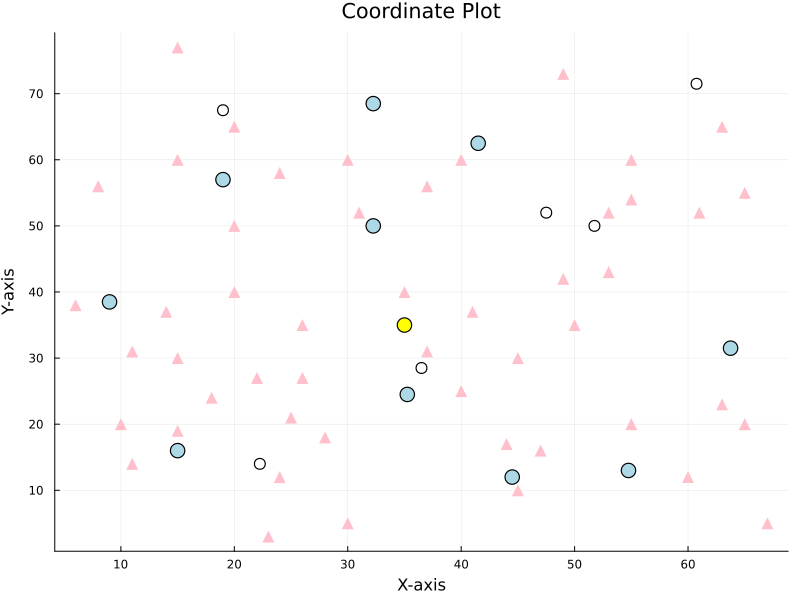

In [5]:
displayMap()

0